In [2]:
import os
import sys
import time

import re
import random
import collections

import numpy as np
import networkx as nx
import tensorflow as tf

from sklearn.manifold import TSNE

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
sep = "\t"
repeat_time = 2**(16-10)

# 1.1 Build-up a Graph by networkx from event_relation.tsv

In [4]:
sep = "\t"

g = nx.Graph()
with open("event_relation1.tsv", "rb") as in_file:
    in_file.next()
    for line in in_file:
        event, people = line.strip().split(sep)
        people = people.split(",")
        
        for curr_idx in range(len(people)):
            for next_idx in range(curr_idx+1, len(people)):
                curr_person = people[curr_idx]
                next_person = people[next_idx]
                
                if g.has_edge(curr_person, next_person):
                    data = g.get_edge_data(curr_person, next_person)
                    g.add_edge(curr_person, next_person, key="edge", weight=data['weight']+1)
                else:
                    g.add_edge(curr_person, next_person, weight=1)

# 1.2 Degree

In [5]:
for idx, (node, degree) in enumerate(sorted(dict(g.degree()).items(), key=lambda x: x[1], reverse=True)):
    print node, degree

people_0218 123
people_0171 123
people_0225 123
people_0183 123
people_0188 123
people_0142 122
people_0179 122
people_0149 121
people_0233 121
people_0190 121
people_0220 121
people_0201 121
people_0184 121
people_0180 121
people_0181 121
people_0140 120
people_0196 120
people_0176 120
people_0222 120
people_0136 120
people_0130 120
people_0213 120
people_0187 120
people_0153 119
people_0138 119
people_0193 119
people_0164 119
people_0241 119
people_0243 119
people_0242 119
people_0148 118
people_0211 118
people_0158 118
people_0156 118
people_0135 118
people_0132 118
people_0200 118
people_0169 118
people_0129 118
people_0143 117
people_0217 117
people_0151 117
people_0133 117
people_0204 117
people_0206 117
people_0186 117
people_0162 117
people_0230 116
people_0235 116
people_0198 116
people_0172 116
people_0174 116
people_0159 116
people_0155 116
people_0157 116
people_0134 116
people_0234 115
people_0236 115
people_0237 115
people_0216 115
people_0202 115
people_0161 115
people_0

# 1.3 Read Gruth-True Labals for People

In [6]:
def read_label(filepath="people_label.txt"):
    labels = {}
    
    with open(filepath, "rb") as in_file:
        for line in in_file:
            people, label = line.strip().split(sep)
            
            labels[people] = int(label)*2.0
            
    return labels

people_labels = read_label()

# 2.1 Apply Random Walk in Graph to describe the network

In [7]:
class RandomWalkInGraph(object):
    def __init__(self, g):
        self.network = g

        self.probability = {}
        self.probability_to_next_vertex()
        
    def probability_to_next_vertex(self):
        for node_start in self.network.nodes():
            self.probability[node_start] = self.network.neighbors(node_start)

    def next_vertex(self, node_start, length=2**5):
        path = [node_start]
        neighbors = self.probability[path[-1]]
        
        while neighbors > 0 and length > 1:
            seed = np.random.choice(neighbors)
            path.append(seed)
            
            neighbors = self.probability[path[-1]]
            length -= 1
            
        return path

    def random_walk(self):
        nodes = self.network.nodes()
        np.random.shuffle(nodes)
        
        for node_start in nodes:
            yield self.next_vertex(node_start)

In [8]:
words = []

rkig = RandomWalkInGraph(g)

timestamp_start = time.time()

for idx in range(repeat_time):
    for path in rkig.random_walk():
        words.extend(path)
    
    if idx%(repeat_time/4) == 0:
        timestamp_end = time.time()

        print "Iteration {:4d}| Spend {:.4f} seconds to add {} into the words".format(idx+1, timestamp_end-timestamp_start, len(words))
        
        timestamp_start = timestamp_end
        
print "The size of words is {}".format(len(words))

count = []
count.extend(collections.Counter(words).most_common(len(set(g.nodes()))))
vocabulary = []

for word, c in sorted(count, key=lambda x: x[1], reverse=True):
    vocabulary.append(word)

print "The size of vocabulary is {}".format(len(vocabulary))

Iteration    1| Spend 0.0709 seconds to add 9184 into the words
Iteration   17| Spend 1.0780 seconds to add 156128 into the words
Iteration   33| Spend 1.0895 seconds to add 303072 into the words
Iteration   49| Spend 1.0799 seconds to add 450016 into the words
The size of words is 587776
The size of vocabulary is 287


# 3.1 Claim the Language Model with SKIPGRAM methodology

In [9]:
class Word2Vec(object):
    SIZE_DICTIONARY = 2**16
    
    def __init__(self, words, 
                 method="skipgram", num_sample=2, window_size=1, embed_dimension=2**8, num_negative_samples=64, 
                 validation_sample=16):
        
        self.method = method
        self.num_sample = num_sample
        self.window_size = window_size
        
        self.embed_dimension = embed_dimension
        self.num_negative_samples = num_negative_samples
        
        self.dictionary = {}
        self.reversed_dictionary = {}
        
        self.batch_idx = 0
        self.training_dataset = []
        
        self.set_dictionaries(words)
        self.set_training_dataset(words)
        self.set_validation_dataset(validation_sample)
        
    def set_dictionaries(self, words):
        count = []
        
        most_common = collections.Counter(words).most_common(self.SIZE_DICTIONARY-1)
        for idx, (word, cc) in enumerate(most_common):
            self.dictionary[word] = len(self.dictionary)
            self.reversed_dictionary[self.dictionary[word]] = word
            
        print("The size of dictionary is {}".format(len(self.dictionary)))
            
    def set_training_dataset(self, words):
        for word in words:
            self.training_dataset.append(self.dictionary[word])
            
        print("The shape of training dataset is {}".format(len(self.training_dataset)))
            
    def set_validation_dataset(self, validation_sample):
        self.validation_dataset = np.array(random.sample(range(64), validation_sample))
            
    def next_batch(self, batch_size):
        assert batch_size%self.num_sample == 0
        assert self.num_sample <= 2*self.window_size
        
        span = 1+2*self.window_size
        
        buffer = collections.deque(maxlen=span)
        def move_on():
            next_word = self.training_dataset[self.batch_idx]
            buffer.append(next_word)
            self.batch_idx = (self.batch_idx+1)%len(self.training_dataset)
            
        for _ in range(span):
            move_on()
            
        datasets, labels = [], []
        for idx in range(batch_size // self.num_sample):
            target_word = self.window_size
            context_word = target_word
            context_words = [context_word]
            
            for _ in range(self.num_sample):
                while context_word in context_words:
                    context_word = np.random.randint(0, span)
                context_words.append(context_word)
                
                datasets.append(buffer[target_word])
                labels.append([buffer[context_word]])
                
            move_on()
            
        return np.array(datasets, dtype=np.int32), np.array(labels, dtype=np.int32)
    
    def train(self, learning_rate=1.0, batch_size=128, n_epoch=2**15, printing_epoch=2**12, top_k=8):
        print("The size of vocabulary is {}, the dimension of embeddings is {}".format(len(self.dictionary), self.embed_dimension))
        print("The shape of validation dataset is {}".format(len(self.validation_dataset)))
        
        tf.reset_default_graph()
        
        train_x = tf.placeholder(tf.int32, shape=[None])
        train_y = tf.placeholder(tf.int32, shape=[None, 1])
        validate_x = tf.constant(self.validation_dataset, dtype=np.int32)
        
        embeddings = tf.Variable(tf.random_uniform([len(self.dictionary), self.embed_dimension], -1.0, 1.0), dtype=tf.float32)
        embeddings_x = tf.nn.embedding_lookup(embeddings, train_x)
        
        softmax_weights = tf.Variable(tf.truncated_normal([len(self.dictionary), self.embed_dimension], 
                                                          stddev=1.0 / np.sqrt(self.embed_dimension)))
        softmax_biases = tf.Variable(tf.zeros([len(self.dictionary)]))
        
        sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                                                          biases=softmax_biases, 
                                                          inputs=embeddings_x,
                                                          labels=train_y, 
                                                          num_sampled=self.num_negative_samples, 
                                                          num_classes=len(self.dictionary))
        loss = tf.reduce_mean(sampled_softmax_loss)
        
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        norm_embeddings = embeddings / norm
        
        embeddings_validation = tf.nn.embedding_lookup(norm_embeddings, validate_x)
        similarity = tf.matmul(embeddings_validation, tf.transpose(norm_embeddings))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            average_loss = 0.0
            timestamp_start = time.time()
            for epoch in range(n_epoch):
                batch_x, batch_y = self.next_batch(batch_size)
                fd = {train_x: batch_x, train_y: batch_y}

                _, l = sess.run([optimizer, loss], feed_dict=fd)
                average_loss += l
                
                if epoch > 0 and (epoch == n_epoch-1 or epoch%printing_epoch == 0):
                    timestamp_end = time.time()
                    
                    print("Epoch {:5d}| seconds: {:3.2f}, average_loss: {:2.12f}".\
                          format(epoch, timestamp_end-timestamp_start, average_loss/printing_epoch))
                    
                    timestamp_start = timestamp_end
                    average_loss = 0.0
        
                if epoch > 0 and (epoch==n_epoch-1 or epoch%(printing_epoch*4) == 0):
                    sim = similarity.eval()
                    for idx, word in enumerate(self.validation_dataset):
                        validation_word = self.reversed_dictionary[word]
                        nearest = (-sim[idx, :]).argsort()[1:top_k+1]
                        log = "Nearest to {}:".format(validation_word)

                        for k in range(top_k):
                            close_word = self.reversed_dictionary[nearest[k]]
                            log = "{} {},".format(log, close_word)
                        
                        print(log)
                        
            self.embeddings = embeddings.eval()
            self.normalized_embeddings = norm_embeddings.eval()

In [10]:
word2vec = Word2Vec(words, num_sample=2, window_size=1, embed_dimension=2**8)
word2vec.train(learning_rate=1.0, n_epoch=2**16, printing_epoch=2**12, top_k=4)

The size of dictionary is 287
The shape of training dataset is 587776
The size of vocabulary is 287, the dimension of embeddings is 256
The shape of validation dataset is 16
Epoch  4096| seconds: 10.30, average_loss: 3.158067568234
Epoch  8192| seconds: 10.94, average_loss: 2.837262217377
Epoch 12288| seconds: 11.43, average_loss: 2.774334918402
Epoch 16384| seconds: 11.59, average_loss: 2.756509532643
Nearest to people_0225: people_0201, people_0183, people_0235, people_0233,
Nearest to people_0204: people_0158, people_0172, people_0156, people_0180,
Nearest to people_0254: people_0264, people_0266, people_0260, people_0246,
Nearest to people_0098: people_0088, people_0108, people_0083, people_0122,
Nearest to people_0264: people_0254, people_0266, people_0250, people_0245,
Nearest to people_0101: people_0091, people_0085, people_0099, people_0083,
Nearest to people_0243: people_0181, people_0153, people_0145, people_0235,
Nearest to people_0247: people_0265, people_0255, people_0253,

In [11]:
class VisualizeEmbeddings(object):
    def __init__(self):
        pass
    
    def cluster_embeddings(self, counts, embeddings, 
                           method=TSNE(perplexity=30, n_components=2, init='pca', n_iter=2**14), 
                           plot_only=2**9):        
        low_dim_embs = method.fit_transform(embeddings[:plot_only,:])
        labels = [counts[i] for i in range(plot_only)]
        
        self.plot_embeddings(low_dim_embs, labels)
    
    def plot_embeddings(self, low_dim_embs, labels):
        global people_labels
        
        assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
        
        plt.figure(figsize=(18, 18))
        for i, label in enumerate(labels):
            x, y = low_dim_embs[i,:]
            plt.annotate(label[7:],
                         xy=(x, y),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        
        plt.scatter(low_dim_embs[:,0], low_dim_embs[:,1], c=[people_labels[label] for label in labels])
        
        plt.colorbar()
        plt.grid()

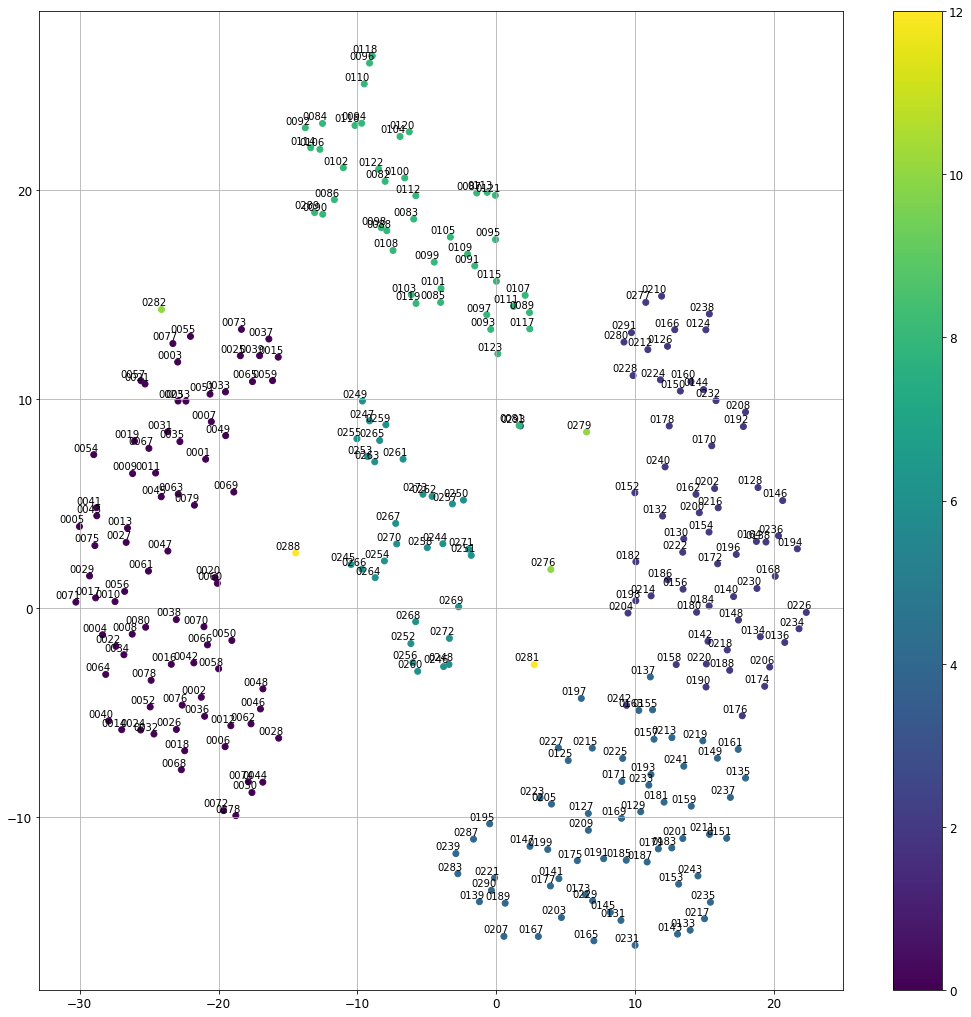

In [12]:
v = VisualizeEmbeddings()
v.cluster_embeddings(vocabulary, word2vec.normalized_embeddings, plot_only=len(vocabulary))

In [16]:
class Dataset(object):
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_examples = len(self.dataset)
        
    def next_batch(self, batch_size):
        total_batch = self.num_examples // batch_size
        
        for idx in range(total_batch):
            idx_start = idx*batch_size
            idx_end = min(self.num_examples, (idx+1)*batch_size)
            
            yield self.dataset[idx_start:idx_end]

class Autoencoder(object):
    def __init__(self, 
                 dimensions,
                 size_coding,
                 activated_fn=tf.nn.elu, 
                 regularizer=None,#tf.contrib.layers.l2_regularizer(0.01), 
                 learning_rate=1e-3,
                 batch_size=128):
        
        tf.reset_default_graph()
        
        self.x = tf.placeholder("float", shape=[None, dimensions[0]])
        self.first_layer = None
        
        prev_layer = self.x
        for dimension in dimensions:
            encoder_layer = tf.contrib.layers.fully_connected(prev_layer, dimension, activation_fn=activated_fn, weights_regularizer=regularizer)
            prev_layer = encoder_layer
            
            if self.first_layer is None:
                self.first_layer = prev_layer
                
        self.coding_layer = tf.contrib.layers.fully_connected(prev_layer, size_coding, activation_fn=activated_fn, weights_regularizer=regularizer)

        prev_layer = self.coding_layer
        for dimension in dimensions[-1::-1]:
            decoder_layer = tf.contrib.layers.fully_connected(prev_layer, dimension, activation_fn=activated_fn, weights_regularizer=regularizer)
            prev_layer = decoder_layer
        
        self.logits = tf.contrib.layers.fully_connected(prev_layer, dimensions[0], activation_fn=tf.nn.sigmoid, weights_regularizer=regularizer)

        self.reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        self.mse = tf.reduce_mean(tf.square(self.logits - self.x))
                    
        self.loss = self.mse + self.reg_loss
        
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
                
    def train(self, X):
        return self.sess.run([self.train_op, self.loss, self.mse, self.reg_loss], feed_dict={self.x: X})
    
    def fit_transform(self, X):
        return self.sess.run(self.coding_layer, feed_dict={self.x: X})
    
    def reconstruct(self, X):
        return self.sess.run(self.logits, feed_dict={self.x: X})
    
def train_autoencoder(dataset, dimensions, size_coding, learning_rate=0.001, batch_size=128, n_epoch=64, printing_epoch=16):
    autoencoder = Autoencoder(dimensions, size_coding, learning_rate=learning_rate, batch_size=batch_size)
    timestamp_start = time.time()
    
    # Training cycle
    for epoch in range(n_epoch):
        avg_loss, avg_reconstruction_loss, avg_l2_loss = 0.0, 0.0, 0.0
        
        # Loop over all batches
        for batch_xs in dataset.next_batch(batch_size):
            _, loss, reconstruction_loss, l2_loss = autoencoder.train(batch_xs)
            
            # Compute average loss
            avg_loss += loss
            avg_reconstruction_loss += reconstruction_loss
            avg_l2_loss += l2_loss
            
        # Display logs per epoch step
        if epoch % printing_epoch == 0 or epoch == n_epoch-1:
            print("Epoch {:3d}: {} seconds, total_cost={:.8f}, reconstruction_loss={:.8f}, l2_loss={:.8f}".format(\
                epoch+1, int(time.time()-timestamp_start), avg_loss, avg_reconstruction_loss, avg_l2_loss))
            
            print(autoencoder.fit_transform(batch_xs[:4]))
            
            timestamp_start = time.time()
            
    return autoencoder

In [ ]:
coding_embeddings = 2
dimensions = [word2vec.embed_dimension, 1024, 256, 64, 16]
word2vec_dataset = Dataset(word2vec.normalized_embeddings)

autoencoder_word2vec = train_autoencoder(word2vec_dataset, 
                                         dimensions, 
                                         coding_embeddings, 
                                         learning_rate=1e-4, n_epoch=2**16, printing_epoch=2**14)

In [ ]:
v = VisualizeEmbeddings()

v.cluster_embeddings(vocabulary, 
                     word2vec_dataset.dataset, 
                     method=autoencoder_word2vec,
                     plot_only=len(vocabulary))